### Look at checking_db.ipynb for data cleaning and initial EDA

Scenario, a friend group wants to create a new podcast, they have a broad field of interests and would like to optimize their new podcast to get traction. They want to know what category to focus their effort at, sports, arts, science etc... 

They also want to get a general insight into how the podcast market has shifted over time



In [140]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
sns.set_style("darkgrid")

In [141]:
con = sqlite3.connect("database.sqlite")
cur = con.cursor()

In [142]:
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb
%config SqlMagic.autopandas = True

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


TABLES in SQL database
* categories
* podcasts
* reviews
* runs


Whats our metrics ? 

Reviews: Rating and key word searches, which keywords to look for ?

Categories

Title, anything in common for most popular podcasts ? 
Anything in common for least popular podcasts ? 

Without looking up individual podcasts, how can we decide on the most popular podcast ? Nr of reviews ? 

Review bombing effects ? 
Negative or positive. Can this be statistically tested ? For more than one podcast or do this for individual podcasts ? 



# Our three main  tables, Reviews, Podcasts and categories
(Delete later)

In [143]:
cur = con.cursor()
prompt = """
SELECT *
FROM podcasts
LIMIT 2
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando


In [144]:
cur = con.cursor()
prompt = """
SELECT *
FROM reviews
LIMIT 2
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00


In [145]:
cur = con.cursor()
prompt = """
SELECT *
FROM Categories
LIMIT 2
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts


# REMEMBER!! DISTINCT PODCAST ID FOR CATEGORIES

In [222]:
cur = con.cursor()
prompt = """
SELECT COUNT(p_id) AS count_of_podcasts
FROM(SELECT DISTINCT(podcast_id) AS p_id
FROM categories)
LIMIT 2
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,count_of_podcasts
0,110024


In [147]:
cur = con.cursor()
prompt = """
SELECT *
FROM podcasts
LIMIT 2
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando


Whats the most popular podcasts ? 

In [148]:
cur = con.cursor()
prompt = """SELECT p.title, COUNT(*) as count, c.category
            FROM reviews r
            JOIN podcasts p
            ON r.podcast_id = p.podcast_id
            JOIN categories c
            ON c.podcast_id = r.podcast_id
            GROUP BY r.podcast_id
            ORDER BY count DESC
            LIMIT 100"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,title,count,category
0,Crime Junkie,33104,true-crime
1,Wow in the World,29094,education
2,My Favorite Murder with Karen Kilgariff and Ge...,21350,comedy
3,Know Your Aura with Mystic Michaela,20236,education
4,Don't Keep Your Day Job,19728,business
...,...,...,...
95,Past Gas by Donut Media,3393,comedy
96,Philosophize This!,3375,education
97,Potterless,3369,arts
98,An Acquired Taste Podcast,3355,comedy


In [149]:
%sql output_df << SELECT SUM(count) AS total FROM df
output_df

Running query in 'duckdb'

,total
0,708044.0


In [150]:
%%sql
SELECT
title,count
FROM df

Running query in 'duckdb'

,title,count
0,Crime Junkie,33104
1,Wow in the World,29094
2,My Favorite Murder with Karen Kilgariff and Ge...,21350
3,Know Your Aura with Mystic Michaela,20236
4,Don't Keep Your Day Job,19728
...,...,...
95,Past Gas by Donut Media,3393
96,Philosophize This!,3375
97,Potterless,3369
98,An Acquired Taste Podcast,3355


Most popular categories from the top 100 podcasts (based on total amount of reviews)

In [151]:
%%sql
top_100_df <<
SELECT 
category, COUNT(title) as count
FROM df
GROUP BY category
ORDER BY count ASC

Running query in 'duckdb'

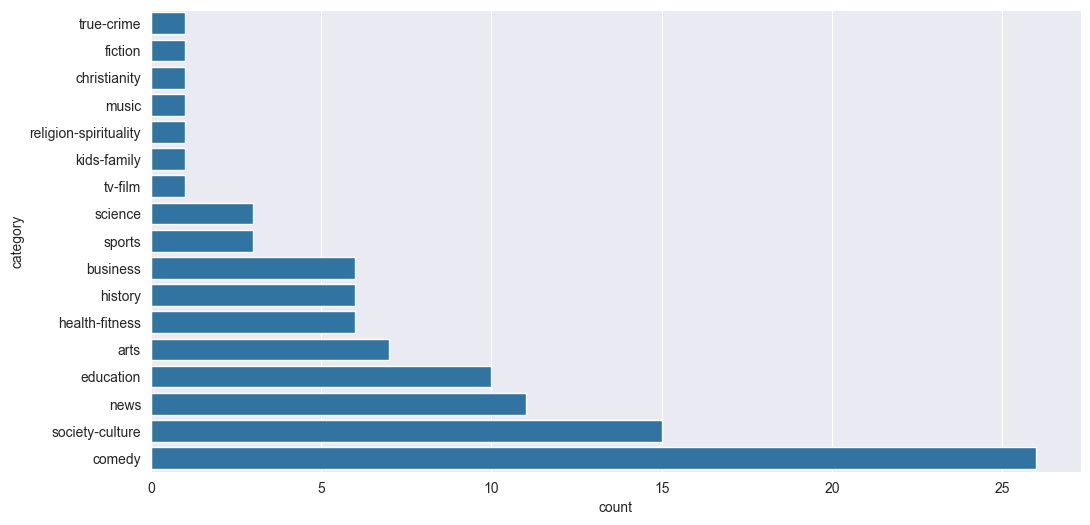

In [152]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(top_100_df, x="count", y="category")


## Problem, podcasts with multiple multi categories

65 379 podcasts have multiple multi categories, this is a problem, however I've noticed this late into the analysis and due to time constraints will move on as if it wasn't the case, I will however keep the evidence here for discussion and possible fixes in the future.

In [153]:
cur = con.cursor()
prompt = """SELECT c.podcast_id, c.category
            FROM categories c
            """
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()

In [154]:
cur = con.cursor()
prompt = """SELECT p.podcast_id, p.title
            FROM podcasts p
            """
cur.execute(prompt)
podcasts_df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()

In [155]:
%%sql
WITH t1 AS (SELECT DISTINCT podcast_id, COUNT(category) as count
FROM df
GROUP BY podcast_id
HAVING count > 1),
t2 AS (SELECT podcast_id, category
FROM df)
SELECT p.podcast_id, p.title, t2.category, t1.count
FROM t1
JOIN t2
ON t1.podcast_id = t2.podcast_id 
JOIN podcasts_df p
ON t1.podcast_id = p.podcast_id
GROUP BY p.podcast_id, p.title, t2.category, t1.count
ORDER BY t1.count DESC, p.podcast_id
LIMIT 15

Running query in 'duckdb'

,podcast_id,title,category,count
0,be905117ff9b3a13b1a065801241903b,Pursue Excellence,education,8
1,be905117ff9b3a13b1a065801241903b,Pursue Excellence,religion-spirituality,8
2,be905117ff9b3a13b1a065801241903b,Pursue Excellence,society-culture,8
3,be905117ff9b3a13b1a065801241903b,Pursue Excellence,society-culture-personal-journals,8
4,be905117ff9b3a13b1a065801241903b,Pursue Excellence,business,8
5,be905117ff9b3a13b1a065801241903b,Pursue Excellence,arts,8
6,be905117ff9b3a13b1a065801241903b,Pursue Excellence,christianity,8
7,be905117ff9b3a13b1a065801241903b,Pursue Excellence,business-entrepreneurship,8
8,c4be70db3c16d3607bd7ae4999cb6e86,FrazerRice.Com,society-culture,8
9,c4be70db3c16d3607bd7ae4999cb6e86,FrazerRice.Com,business-entrepreneurship,8


In [223]:
cur = con.cursor()
prompt = """WITH tab AS(WITH t1 AS(SELECT DISTINCT c.podcast_id, COUNT(c.category) as count
            FROM categories c
            GROUP BY c.podcast_id),
            t2 AS (SELECT c.podcast_id, c.category
            FROM categories c)
            SELECT p.title, COUNT(t2.category) AS categories_per_podcast
            FROM t1
            JOIN t2
            ON t1.podcast_id = t2.podcast_id 
            JOIN podcasts p
            ON t1.podcast_id = p.podcast_id
            GROUP BY p.title
            ORDER BY count DESC
            )
            SELECT tab.categories_per_podcast, COUNT(tab.title) AS nr_of_podcasts
            FROM tab
            GROUP BY tab.categories_per_podcast
            """
cur.execute(prompt)
multi_category_podcasts = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
print(multi_category_podcasts['nr_of_podcasts'].sum())
multi_category_podcasts

109274


,categories_per_podcast,nr_of_podcasts
0,1,43707
1,2,39162
2,3,16530
3,4,8914
4,5,733
5,6,185
6,7,33
7,8,7
8,9,2
9,15,1


<Axes: xlabel='categories_per_podcast', ylabel='nr_of_podcasts'>

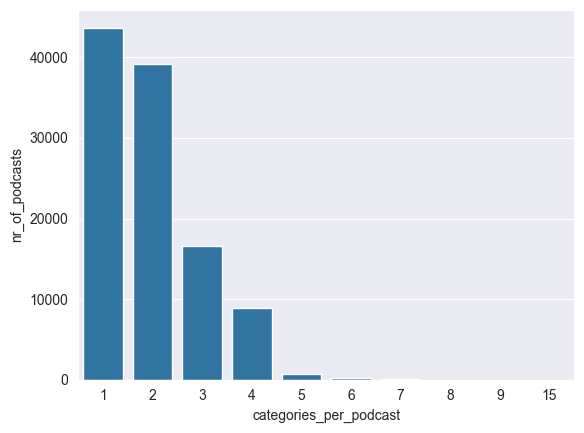

In [224]:
sns.barplot(multi_category_podcasts, x='categories_per_podcast',y='nr_of_podcasts')

### Splitting the multi categories into a table with one sub-category in each column

At most the categories consist out of 5 sub-categories, whenever a podcast has less  than 5 categories, subsequent category columns is filled with None values

In [158]:
%%sql
split_df <<
SELECT
podcast_id,
SPLIT_PART(category, '-', 1) AS category1,
SPLIT_PART(category, '-', 2) AS category2,
SPLIT_PART(category, '-', 3) AS category3,
SPLIT_PART(category, '-', 4) AS category4,
SPLIT_PART(category, '-', 5) AS category5,
SPLIT_PART(category, '-', 6) AS category6,
FROM df

Running query in 'duckdb'

In [159]:
split_df[0:5]

,podcast_id,category1,category2,category3,category4,category5,category6
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts,,,,,
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts,performing,arts,,,
2,c61aa81c9b929a66f0c1db6cbe5d8548,music,,,,,
3,ad4f2bf69c72b8db75978423c25f379e,arts,,,,,
4,ad4f2bf69c72b8db75978423c25f379e,arts,design,,,,


Cannot get this one too work, any tips ? 

In [160]:
%%sql 
WITH t1 AS (
SELECT category5,
CASE WHEN TRIM(category5) = '' THEN NULL ELSE category5 END as category5_1
FROM split_df
)
SELECT category5, COUNT(category5) AS count
FROM t1
WHERE t1.category5_1 IS NOT NULL
GROUP BY category5


Running query in 'duckdb'

,category5,count
0,kids,516


There are up to 5 different sub categories for each "category" of podcast, SELECT DISTINCT category6 returns 0

In [161]:
%%sql
SELECT DISTINCT category6
FROM split_df

Running query in 'duckdb'

,category6
0,


Turning all empty cells into NULL values. 

In [162]:
%%sql
split_df <<
SELECT podcast_id, 
category1_1 AS category1,
category2_1 AS category2,
category3_1 AS category3,
category4_1 AS category4,
category5_1 AS category5, 
FROM (SELECT *,
CASE WHEN TRIM(category1) = '' THEN NULL ELSE category1 END as category1,
CASE WHEN TRIM(category2) = '' THEN NULL ELSE category2 END as category2,
CASE WHEN TRIM(category3) = '' THEN NULL ELSE category3 END as category3,
CASE WHEN TRIM(category4) = '' THEN NULL ELSE category4 END as category4,
CASE WHEN TRIM(category5) = '' THEN NULL ELSE category5 END as category5,
FROM split_df)

Running query in 'duckdb'

In [163]:
split_df

,podcast_id,category1,category2,category3,category4,category5
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts,None,None,None,None
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts,performing,arts,None,None
2,c61aa81c9b929a66f0c1db6cbe5d8548,music,None,None,None,None
3,ad4f2bf69c72b8db75978423c25f379e,arts,None,None,None,None
4,ad4f2bf69c72b8db75978423c25f379e,arts,design,None,None,None
...,...,...,...,...,...,...
212367,da8331a8fbbba6fe1e2653f2fa86e168,news,None,None,None,None
212368,da8331a8fbbba6fe1e2653f2fa86e168,news,news,commentary,None,None
212369,da8331a8fbbba6fe1e2653f2fa86e168,science,None,None,None,None
212370,d41b3b7b2413fcf202d8bef1512554dc,islam,None,None,None,None


### Creating a temporary table, from multiple temporary tables to count the total number of times a sub category appears



In [228]:
%%sql
sub_categories_df <<
WITH table_ultimate AS(
WITH t AS(
    SELECT category1 AS category
    FROM split_df
    UNION
    SELECT category2
    FROM split_df
    UNION
    SELECT category3
    FROM split_df
    UNION
    SELECT category4
    FROM split_df
    UNION
    SELECT category5
    FROM split_df
),
t1 AS(
    SELECT COUNT(podcast_id) as count1, category1
    FROM split_df
    GROUP BY category1
    ),
t2 AS(
    SELECT COUNT(podcast_id) as count2, category2
    FROM split_df
    GROUP BY category2
),
t3 AS(
    SELECT COUNT(podcast_id) as count3, category3
    FROM split_df
    GROUP BY category3
),
t4 AS(
    SELECT COUNT(podcast_id) as count4, category4
    FROM split_df
    GROUP BY category4
),
t5 AS(
    SELECT COUNT(podcast_id) as count5, category5
    FROM split_df
    GROUP BY category5
)
SELECT t.category, t1.count1, t2.count2, t3.count3, t4.count4, t5.count5
FROM t
LEFT JOIN t1
ON t.category = t1.category1
LEFT JOIN t2
ON t.category = t2.category2
LEFT JOIN t3
ON t.category = t3.category3
LEFT JOIN t4
ON t.category = t4.category4
LEFT JOIN t5
ON t.category = t5.category5)
SELECT category, IFNULL(count1, 0) + IFNULL(count2, 0) + IFNULL(count3, 0) + IFNULL(count4, 0) + IFNULL(count5, 0) AS total_count
FROM table_ultimate
ORDER BY total_count DESC

Running query in 'duckdb'

In [227]:
split_df

,podcast_id,category1,category2,category3,category4,category5
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts,None,None,None,None
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts,performing,arts,None,None
2,c61aa81c9b929a66f0c1db6cbe5d8548,music,None,None,None,None
3,ad4f2bf69c72b8db75978423c25f379e,arts,None,None,None,None
4,ad4f2bf69c72b8db75978423c25f379e,arts,design,None,None,None
...,...,...,...,...,...,...
212367,da8331a8fbbba6fe1e2653f2fa86e168,news,None,None,None,None
212368,da8331a8fbbba6fe1e2653f2fa86e168,news,news,commentary,None,None
212369,da8331a8fbbba6fe1e2653f2fa86e168,science,None,None,None,None
212370,d41b3b7b2413fcf202d8bef1512554dc,islam,None,None,None,None


In [229]:
sub_categories_df

,category,total_count
0,culture,27594
1,society,27594
2,business,22922
3,education,20988
4,arts,19095
...,...,...
112,physics,18
113,chemistry,17
114,mathematics,16
115,volleyball,14


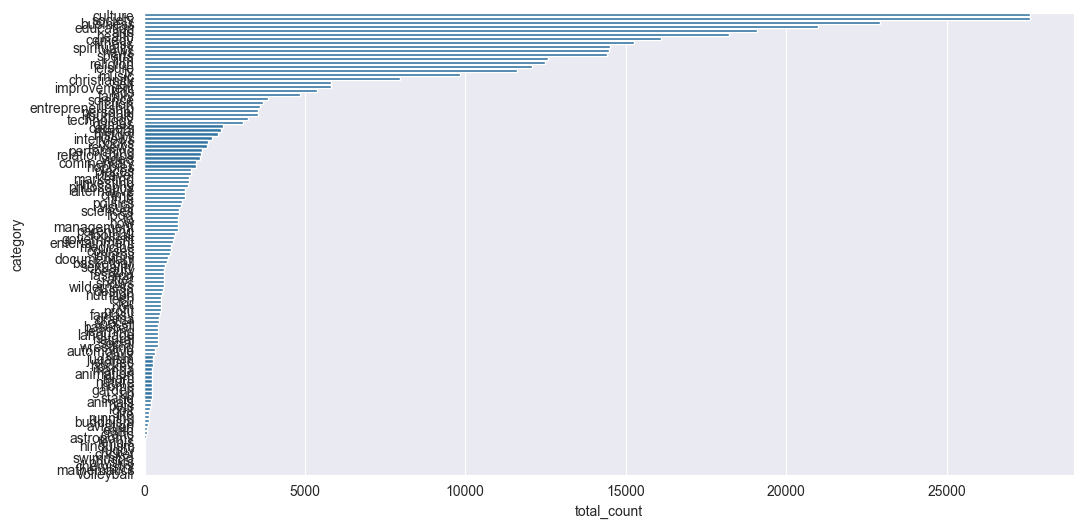

In [166]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(sub_categories_df, x="total_count", y="category")

### The sub categories society and culture always appears in "the same" category, these will be treated as one and the same for the rest of the analysis

In [167]:
cur = con.cursor()
prompt = """
WITH t1 AS(
SELECT category, COUNT(podcast_id) as count
FROM categories
WHERE category LIKE '%society%'
GROUP BY category
ORDER BY count DESC),
t2 AS(
SELECT category AS category_2, COUNT(podcast_id) as count_2
FROM categories
WHERE category LIKE '%culture%'
GROUP BY category_2
ORDER BY count_2 DESC
)
SELECT *, t1.count - t2.count_2 AS difference
FROM t1
JOIN t2
ON t1.category = t2.category_2
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,category,count,category_2,count_2,difference
0,society-culture,18710,society-culture,18710,0
1,society-culture-personal-journals,3545,society-culture-personal-journals,3545,0
2,society-culture-relationships,1780,society-culture-relationships,1780,0
3,society-culture-places-travel,1462,society-culture-places-travel,1462,0
4,society-culture-philosophy,1365,society-culture-philosophy,1365,0
5,society-culture-documentary,732,society-culture-documentary,732,0


In [168]:
cur = con.cursor()
prompt = """
SELECT category, COUNT(podcast_id) as count
FROM categories
WHERE category LIKE '%culture%'
GROUP BY category
ORDER BY count DESC
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,category,count
0,society-culture,18710
1,society-culture-personal-journals,3545
2,society-culture-relationships,1780
3,society-culture-places-travel,1462
4,society-culture-philosophy,1365
5,society-culture-documentary,732


In [169]:
cur = con.cursor()
prompt = """
SELECT *
FROM reviews
LIMIT 10

"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00
5,ad4f2bf69c72b8db75978423c25f379e,Waste of time,I listened to the “Spanish Flu” pod cast. Afte...,1,67A452C80BCBEEC,2019-01-09T09:07:09-07:00
6,ad4f2bf69c72b8db75978423c25f379e,Too much victimology,Too much BS trying to convince me of how racis...,3,265ADD6AB150C41,2019-02-02T10:15:25-07:00
7,ad4f2bf69c72b8db75978423c25f379e,Politically biased,I would love to hear topics discussed without ...,1,C27BC8C2D6F5A4A,2019-01-01T09:47:11-07:00
8,ad4f2bf69c72b8db75978423c25f379e,😀😃,Ok so I am in love with this podcast.,5,218EE494C8C787F,2019-05-09T17:50:14-07:00
9,ad4f2bf69c72b8db75978423c25f379e,Volume???,"Great podcast, but the editors turn the volume...",1,DC6DBB8C4D9B2E5,2019-06-25T05:05:24-07:00


## Problem, duplicated reviews

Same review author leaves multiple reviews on each podcast

In [170]:
cur = con.cursor()
prompt = """
SELECT p.title AS podcast, r.author_id, r.title AS review_title, COUNT(r.title) count
FROM reviews r
JOIN podcasts p
ON r.podcast_id = p.podcast_id
GROUP BY podcast, r.author_id, review_title
HAVING count > 15
ORDER BY podcast, count DESC
LIMIT 10
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,podcast,author_id,review_title,count
0,Armchair Expert with Dax Shepard,791F376ACA3C08D,"Dear Dax,",34
1,Cinephile with Adnan Virk,1E512E5838C75A3,Review,19
2,Congratulations with Chris D'Elia,791F376ACA3C08D,"Dear Chris,",31
3,Crime in Sports,2B41027753A6C39,All the sports .. all the crime!,24
4,Crime in Sports,795D9E737FD970A,Review,24
5,DnDnD,2AA5C9E5F647668,Can't Stop Listening,18
6,Fitzdog Radio,791F376ACA3C08D,"Dear Greg,",29
7,Fitzdog Radio,61ED6D289B34165,"Dear Greg,",27
8,Golic & Smetty,8167974065A0260,Golic SR And Smetty,16
9,Le Batard & Friends - South Beach Sessions,8167974065A0260,Dan,31


In [171]:
cur = con.cursor()
prompt = """
SELECT p.podcast_id, p.title AS podcast, r.author_id, r.title AS review_title, COUNT(r.title) AS one_review_per_author_per_podcast
FROM reviews r
JOIN podcasts p
ON r.podcast_id = p.podcast_id
GROUP BY podcast, r.author_id, review_title
HAVING one_review_per_author_per_podcast = 1
ORDER BY one_review_per_author_per_podcast DESC
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df[0:2]

,podcast_id,podcast,author_id,review_title,one_review_per_author_per_podcast
0,a461252c09ccc5f142bd604ef9a40fcd,! Weird Rap Podcast !,189068CD52A9AA5,Keep it weird,1
1,a461252c09ccc5f142bd604ef9a40fcd,! Weird Rap Podcast !,199C3835F333D11,Biased review,1


In [172]:
%%sql
one_review_df <<
SELECT podcast_id, podcast, COUNT(review_title) AS num_of_reviews
FROM df
GROUP BY podcast, podcast_id
ORDER BY num_of_reviews DESC


Running query in 'duckdb'

In [173]:
%%sql
SELECT *
FROM one_review_df

Running query in 'duckdb'

,podcast_id,podcast,num_of_reviews
0,bf5bf76d5b6ffbf9a31bba4480383b7f,Crime Junkie,31052
1,bc5ddad3898e0973eb541577d1df8004,My Favorite Murder with Karen Kilgariff and Ge...,9727
2,f5fce0325ac6a4bf5e191d6608b95797,The Ben Shapiro Show,7464
3,b1a3eb2aa8e82ecbe9c91ed9a963c362,True Crime Obsessed,6677
4,bad6c91efdbee814db985c7a65199604,Wow in the World,5565
...,...,...,...
109989,c5c4164a983c831bbdd988e650f9eb47,"Thirty-Five, a podcast",1
109990,b3e674bfffc88f5e557d7de9c9f42911,This Authentic Life,1
109991,c30bbe76310b82ebfd400500219261f3,This IM Possible Life Podcast,1
109992,ff0707dc513ad373f55a00b477ad630e,This Intentional Life,1


In [174]:
%%sql
SELECT * 
FROM split_df s
JOIN one_review_df o
ON o.podcast_id = s.podcast_id
WHERE o.podcast_id <> s.podcast_id

Running query in 'duckdb'

,podcast_id,category1,category2,category3,category4,category5,podcast_id_1,podcast,num_of_reviews


## Trying to solve duplicate problem in split-table, see cheking_db.ipynb under header "Trying to solve duplicate problem in split categories table". 

Due to time contraints and not being able to figure this one out, I've decided to simplify it and use the "original" full categories for each podcast, these will also include a duplicate problem, however less severe, hopefully I will have this one figured out by the time of the review.

In [175]:
cur = con.cursor()
prompt = """
SELECT *
FROM categories
"""
cur.execute(prompt)
categories_df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
categories_df

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design
...,...,...
212367,da8331a8fbbba6fe1e2653f2fa86e168,news
212368,da8331a8fbbba6fe1e2653f2fa86e168,news-news-commentary
212369,da8331a8fbbba6fe1e2653f2fa86e168,science
212370,d41b3b7b2413fcf202d8bef1512554dc,islam


### On average 1.93 categories per podcast (Don't confuse this with sub-categories)

Eg. arts-performing-arts is one category

In [176]:
%%sql
WITH t1 AS(
SELECT SUM(category_count) AS count_podcast_category_combo
FROM (
SELECT podcast_id, COUNT(category) AS category_count
FROM categories_df
GROUP BY podcast_id)
),
t2 AS(
SELECT COUNT(podcast_id) AS count_podcasts
FROM one_review_df
)
SELECT t1.count_podcast_category_combo, count_podcasts, count_podcast_category_combo/count_podcasts AS average_category_per_podcast
FROM t1
CROSS JOIN t2

Running query in 'duckdb'

,count_podcast_category_combo,count_podcasts,average_category_per_podcast
0,212372.0,109994,1.93076


In [177]:
%%sql
SELECT category, COUNT(podcast_id) AS count
FROM(SELECT DISTINCT podcast_id, category 
FROM categories_df)
GROUP BY category
ORDER BY count DESC


Running query in 'duckdb'

,category,count
0,society-culture,18710
1,education,12628
2,comedy,12464
3,religion-spirituality,12190
4,business,12058
...,...,...
105,sports-swimming,18
106,science-physics,18
107,science-chemistry,17
108,science-mathematics,16


In [178]:
%%sql
review_category_df <<
WITH category_count_table AS(
SELECT category, COUNT(podcast_id) AS count
FROM(SELECT DISTINCT podcast_id, category 
FROM categories_df)
GROUP BY category  
)
SELECT r.podcast, r.num_of_reviews, c.category, cct.count AS category_count
FROM one_review_df r
JOIN categories_df c
ON r.podcast_id = c.podcast_id
JOIN category_count_table as cct
ON c.category = cct.category
ORDER BY num_of_reviews DESC

Running query in 'duckdb'

In [179]:
%%sql
SELECT COUNT(*)
FROM review_category_df

Running query in 'duckdb'

,count_star()
0,212319


<Axes: xlabel='num_of_reviews', ylabel='category_count'>

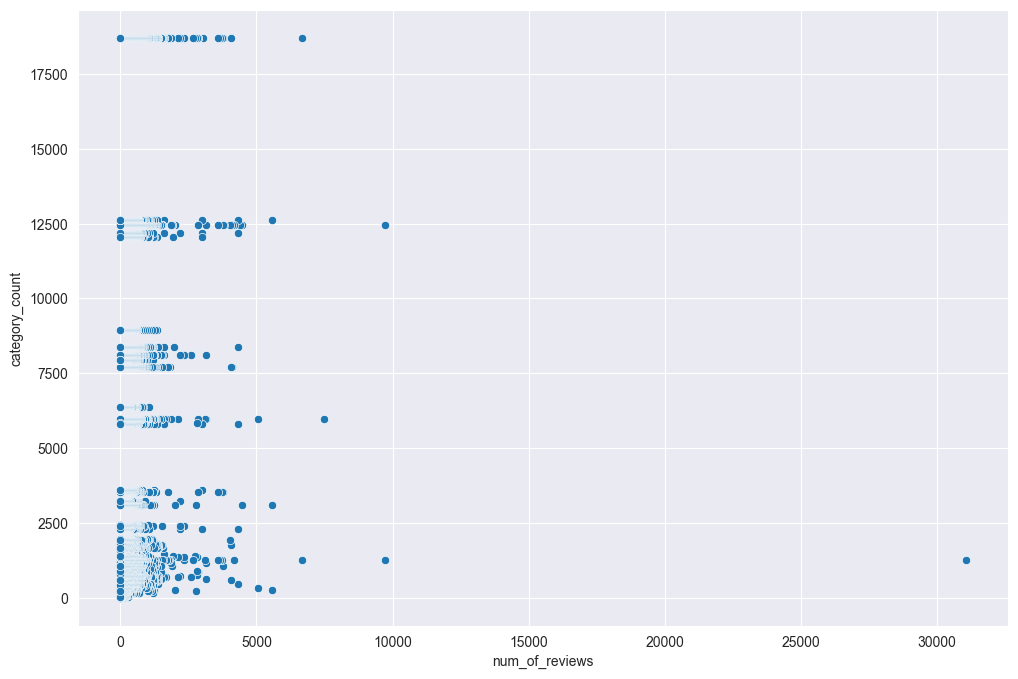

In [180]:
plt.figure(figsize=(12,8))
sns.scatterplot(review_category_df, x="num_of_reviews", y="category_count")

<Figure size 1200x800 with 0 Axes>

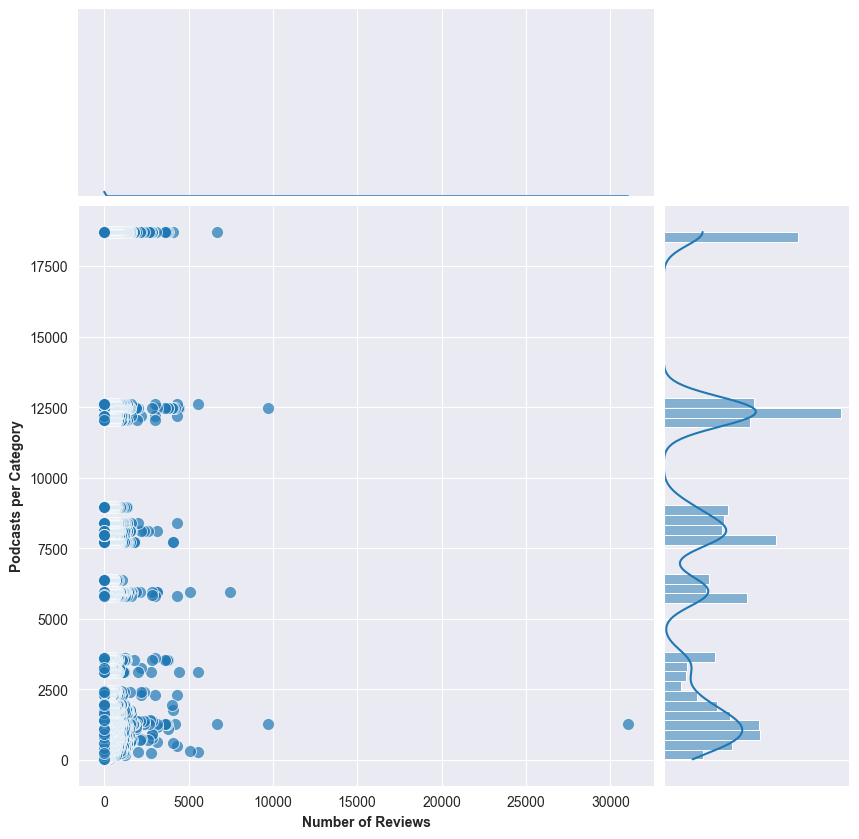

In [181]:
plt.figure(figsize=(12,8))
g = sns.JointGrid(
    data=review_category_df,
    x="num_of_reviews",
    y="category_count",
    height=8.5,
    ratio=3,
    space=0.05,
)
g.ax_joint.set_xlabel("Number of Reviews", fontweight="bold")
g.ax_joint.set_ylabel("Podcasts per Category", fontweight="bold")
g.plot_joint(sns.scatterplot, s=75, alpha=0.7)
g.plot_marginals(sns.histplot, kde=True)

There are 212 000 rows in the review_category_df, when we filter for Podcasts with more than 10 reviews its down to 48 000
48 000

In [182]:
%%sql
review_category_df_2 <<
SELECT *
FROM review_category_df
WHERE num_of_reviews > 10

Running query in 'duckdb'

In [183]:
review_category_df_2

,podcast,num_of_reviews,category,category_count
0,Crime Junkie,31052,true-crime,1264
1,My Favorite Murder with Karen Kilgariff and Ge...,9727,comedy,12464
2,My Favorite Murder with Karen Kilgariff and Ge...,9727,true-crime,1264
3,The Ben Shapiro Show,7464,news,5963
4,True Crime Obsessed,6677,true-crime,1264
...,...,...,...,...
48416,One Weird Trick!,11,education,12628
48417,Hemp Barons,11,business,12058
48418,Harvard College's Computer Science 50: Introdu...,11,education,12628
48419,Ruining Our Childhood,11,tv-film-film-reviews,1172


<Figure size 1200x800 with 0 Axes>

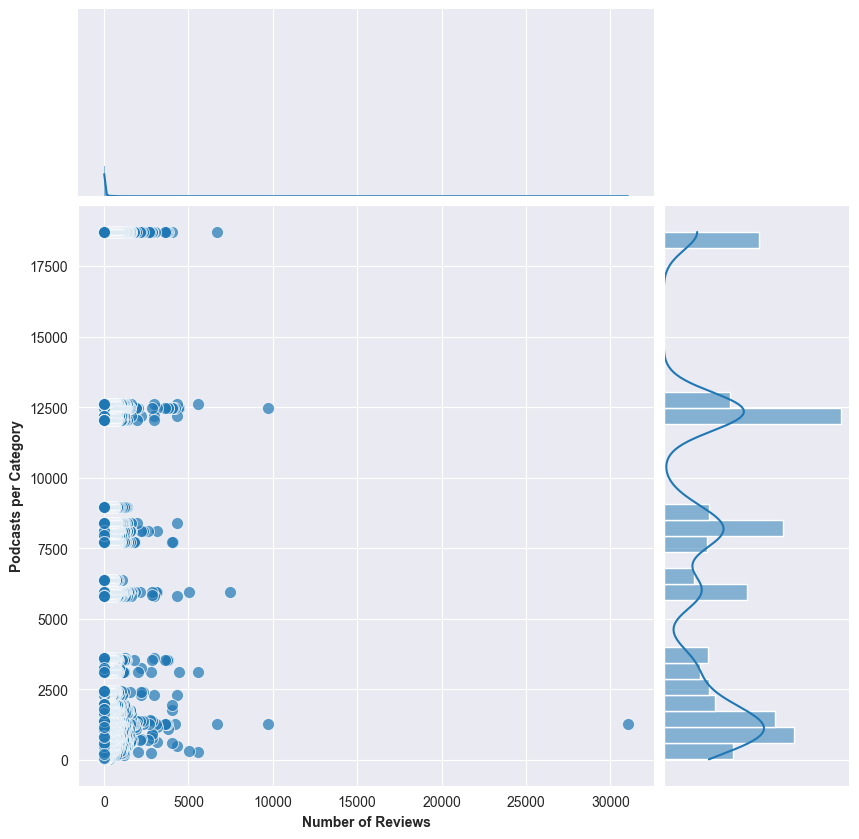

In [184]:
plt.figure(figsize=(12,8))
g = sns.JointGrid(
    data=review_category_df_2,
    x="num_of_reviews",
    y="category_count",
    height=8.5,
    ratio=3,
    space=0.05,
)
g.ax_joint.set_xlabel("Number of Reviews", fontweight="bold")
g.ax_joint.set_ylabel("Podcasts per Category", fontweight="bold")
g.plot_joint(sns.scatterplot, s=75, alpha=0.7)
g.plot_marginals(sns.histplot, kde=True)

## We need to Focus this analysis more, we'll find the top 100 podcasts and do the same analysis from there

In [185]:
%%sql
top_100_reviews_df <<
SELECT *
FROM one_review_df
ORDER BY num_of_reviews DESC
LIMIT 100

Running query in 'duckdb'

In [186]:
%%sql
top_100_category_review_df <<
WITH category_count_table AS(
SELECT category, COUNT(podcast_id) AS count
FROM(SELECT DISTINCT podcast_id, category 
FROM categories_df)
GROUP BY category  
)
SELECT r.podcast, r.num_of_reviews, c.category, cct.count AS category_count
FROM top_100_reviews_df r
JOIN categories_df c
ON r.podcast_id = c.podcast_id
JOIN category_count_table as cct
ON c.category = cct.category
ORDER BY num_of_reviews DESC

Running query in 'duckdb'

In [187]:
top_100_category_review_df

,podcast,num_of_reviews,category,category_count
0,Crime Junkie,31052,true-crime,1264
1,My Favorite Murder with Karen Kilgariff and Ge...,9727,comedy,12464
2,My Favorite Murder with Karen Kilgariff and Ge...,9727,true-crime,1264
3,The Ben Shapiro Show,7464,news,5963
4,True Crime Obsessed,6677,society-culture,18710
...,...,...,...,...
230,Fantastic Geeks,1223,tv-film,7714
231,Fantastic Geeks,1223,tv-film-film-reviews,1172
232,American History Tellers,1221,history,1663
233,American History Tellers,1221,kids-family,3110


<Figure size 1200x800 with 0 Axes>

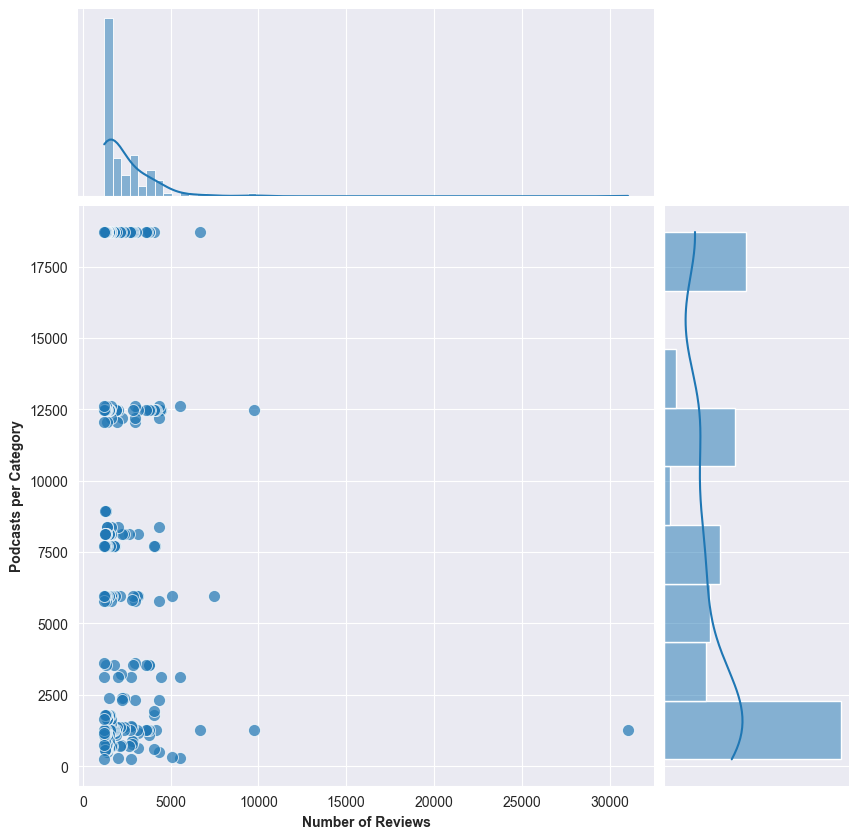

In [188]:
plt.figure(figsize=(12,8))
g = sns.JointGrid(
    data=top_100_category_review_df,
    x="num_of_reviews",
    y="category_count",
    height=8.5,
    ratio=3,
    space=0.05,
)
g.ax_joint.set_xlabel("Number of Reviews", fontweight="bold")
g.ax_joint.set_ylabel("Podcasts per Category", fontweight="bold")
g.plot_joint(sns.scatterplot, s=75, alpha=0.7)
g.plot_marginals(sns.histplot, kde=True)

<Figure size 1200x800 with 0 Axes>

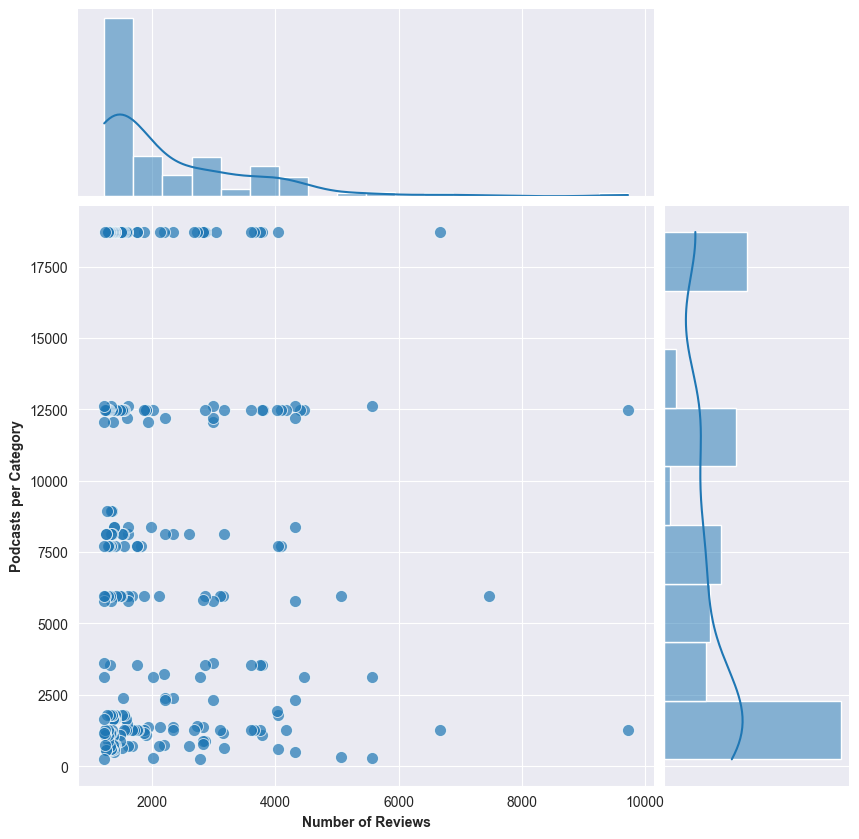

In [189]:
top_100_category_review_df_2 = top_100_category_review_df[(top_100_category_review_df["num_of_reviews"] < 30_000)]
plt.figure(figsize=(12,8))
g = sns.JointGrid(
    data=top_100_category_review_df_2,
    x="num_of_reviews",
    y="category_count",
    height=8.5,
    ratio=3,
    space=0.05,
)
g.ax_joint.set_xlabel("Number of Reviews", fontweight="bold")
g.ax_joint.set_ylabel("Podcasts per Category", fontweight="bold")
g.plot_joint(sns.scatterplot, s=75, alpha=0.7)
g.plot_marginals(sns.histplot, kde=True)

In [225]:
cur = con.cursor()
prompt = """WITH tab AS(WITH t1 AS(SELECT DISTINCT c.podcast_id, COUNT(c.category) as count
            FROM categories c
            GROUP BY c.podcast_id),
            t2 AS (SELECT c.podcast_id, c.category
            FROM categories c)
            SELECT p.title, COUNT(t2.category) AS categories_per_podcast
            FROM t1
            JOIN t2
            ON t1.podcast_id = t2.podcast_id 
            JOIN podcasts p
            ON t1.podcast_id = p.podcast_id
            GROUP BY p.title
            ORDER BY count DESC
            )
            SELECT tab.categories_per_podcast, COUNT(tab.title) AS nr_of_podcasts
            FROM tab
            GROUP BY tab.categories_per_podcast
            """
cur.execute(prompt)
multi_category_podcasts = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
print(multi_category_podcasts['nr_of_podcasts'].sum())
multi_category_podcasts

109274


,categories_per_podcast,nr_of_podcasts
0,1,43707
1,2,39162
2,3,16530
3,4,8914
4,5,733
5,6,185
6,7,33
7,8,7
8,9,2
9,15,1


In [191]:
split_df

,podcast_id,category1,category2,category3,category4,category5
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts,None,None,None,None
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts,performing,arts,None,None
2,c61aa81c9b929a66f0c1db6cbe5d8548,music,None,None,None,None
3,ad4f2bf69c72b8db75978423c25f379e,arts,None,None,None,None
4,ad4f2bf69c72b8db75978423c25f379e,arts,design,None,None,None
...,...,...,...,...,...,...
212367,da8331a8fbbba6fe1e2653f2fa86e168,news,None,None,None,None
212368,da8331a8fbbba6fe1e2653f2fa86e168,news,news,commentary,None,None
212369,da8331a8fbbba6fe1e2653f2fa86e168,science,None,None,None,None
212370,d41b3b7b2413fcf202d8bef1512554dc,islam,None,None,None,None


In [192]:
%%sql
split_df_2 <<
SELECT
podcast_id,
SPLIT_PART(category, '-', 1) AS category1,
SPLIT_PART(category, '-', 2) AS category2,
SPLIT_PART(category, '-', 3) AS category3,
SPLIT_PART(category, '-', 4) AS category4,
SPLIT_PART(category, '-', 5) AS category5,
SPLIT_PART(category, '-', 6) AS category6,
FROM categories_df

Running query in 'duckdb'

In [193]:
%%sql
SELECT *
FROM split_df_2
WHERE category4 != ''

Running query in 'duckdb'

,podcast_id,category1,category2,category3,category4,category5,category6
0,bcc39564de18eba3b028aa591e0c9bdd,society,culture,personal,journals,,
1,f4a8f753bd3959e2a631f2eba3c98172,society,culture,personal,journals,,
2,efc5ef757a02aaa164938e36db60b461,society,culture,personal,journals,,
3,ebd3c5a59c3f95d1d0c698bd99280c46,society,culture,places,travel,,
4,e493f08d17c8cedc8bcfc515f9d800a7,health,fitness,mental,health,,
...,...,...,...,...,...,...,...
12510,e1c4fd7f104b0585f4803e0c257e99df,society,culture,personal,journals,,
12511,fabe4d65999cbaef6181bed1ee40d898,society,culture,personal,journals,,
12512,f77dfc6ffd9e1ed5f852dc182505074d,health,fitness,alternative,health,,
12513,ea37c71d14656652af7e01b2e96e74b8,society,culture,personal,journals,,


In [194]:
categories_df

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design
...,...,...
212367,da8331a8fbbba6fe1e2653f2fa86e168,news
212368,da8331a8fbbba6fe1e2653f2fa86e168,news-news-commentary
212369,da8331a8fbbba6fe1e2653f2fa86e168,science
212370,d41b3b7b2413fcf202d8bef1512554dc,islam


In [195]:
%%sql
duped_categories_df <<
SELECT podcast_id, STRING_AGG(category, '-') AS category
FROM categories_df
GROUP BY podcast_id

Running query in 'duckdb'

This is the only way i found, brute force

In [196]:
%%sql
split_dupe_df <<
SELECT
podcast_id,
SPLIT_PART(category, '-', 1) AS category1,
SPLIT_PART(category, '-', 2) AS category2,
SPLIT_PART(category, '-', 3) AS category3,
SPLIT_PART(category, '-', 4) AS category4,
SPLIT_PART(category, '-', 5) AS category5,
SPLIT_PART(category, '-', 6) AS category6,
SPLIT_PART(category, '-', 7) AS category7,
SPLIT_PART(category, '-', 8) AS category8,
SPLIT_PART(category, '-', 9) AS category9,
SPLIT_PART(category, '-', 10) AS category10,
SPLIT_PART(category, '-', 11) AS category11,
SPLIT_PART(category, '-', 12) AS category12,
SPLIT_PART(category, '-', 13) AS category13,
SPLIT_PART(category, '-', 14) AS category14,
SPLIT_PART(category, '-', 15) AS category15,
SPLIT_PART(category, '-', 16) AS category16,
SPLIT_PART(category, '-', 17) AS category17,
SPLIT_PART(category, '-', 18) AS category18,
SPLIT_PART(category, '-', 19) AS category19,
SPLIT_PART(category, '-', 20) AS category20,
FROM duped_categories_df
ORDER BY category20 DESC


Running query in 'duckdb'

In [197]:
%%sql
SELECT podcast_id, category1,
CASE WHEN TRIM(category2) = category1 THEN '0' ELSE category2 END AS cat1,

CASE WHEN TRIM(category3) = category1 OR TRIM(category3) = category2 THEN '0' ELSE category3 END AS cat2,

CASE WHEN TRIM(category4) = category1 OR TRIM(category4) = category2 OR TRIM(category4) = category3 THEN '0' ELSE category4 END AS cat3,

CASE WHEN TRIM(category5) = category1 OR TRIM(category5) = category2 OR TRIM(category5) = category3 OR 
TRIM(category5) = category4 THEN '0' ELSE category5 END AS cat5,

CASE WHEN TRIM(category6) = category1 OR TRIM(category6) = category2 OR TRIM(category6) = category3 OR TRIM(category6) = category4 OR TRIM(category6) = category5 THEN '0' ELSE category6 END AS cat6,

CASE WHEN TRIM(category7) = category1 OR TRIM(category7) = category2 OR TRIM(category7) = category3 OR TRIM(category7) = category4 OR TRIM(category7) = category5 OR TRIM(category7) = category6 THEN '0' ELSE category7 END AS cat7,

CASE WHEN TRIM(category8) = category1 OR TRIM(category8) = category2 OR TRIM(category8) = category3 OR TRIM(category8) = category4 OR TRIM(category8) = category5 OR TRIM(category8) = category6 OR TRIM(category8) = category7 THEN '0' ELSE category8 END AS cat8,

CASE WHEN TRIM(category9) = category1 OR TRIM(category9) = category2 OR TRIM(category9) = category3 OR TRIM(category9) = category4 OR TRIM(category9) = category5 OR TRIM(category9) = category6 OR TRIM(category9) = category7 OR TRIM(category9) = category8  THEN '0' ELSE category9 END AS cat9,

CASE WHEN TRIM(category10) = category1 OR TRIM(category10) = category2 OR TRIM(category10) = category3 OR TRIM(category10) = category4 OR TRIM(category10) = category5 OR TRIM(category10) = category6 OR TRIM(category10) = category7 OR TRIM(category10) = category8  OR TRIM(category10) = category9 THEN '0' ELSE category10 END AS cat10,

CASE WHEN TRIM(category11) = category1 OR TRIM(category11) = category2 OR TRIM(category11) = category3 OR TRIM(category11) = category4 OR TRIM(category11) = category5 OR TRIM(category11) = category6 OR TRIM(category11) = category7 OR TRIM(category11) = category8  OR TRIM(category11) = category9 OR TRIM(category11) = category10 THEN '0' ELSE category11 END AS cat11,

CASE WHEN TRIM(category12) = category1 OR TRIM(category12) = category2 OR TRIM(category12) = category3 OR TRIM(category12) = category4 OR TRIM(category12) = category5 OR TRIM(category12) = category6 OR TRIM(category12) = category7 OR TRIM(category12) = category8  OR TRIM(category12) = category9 OR TRIM(category12) = category10 OR TRIM(category12) = category11 THEN '0' ELSE category12 END AS cat12,

CASE WHEN TRIM(category13) = category1 OR TRIM(category13) = category2 OR TRIM(category13) = category3 OR TRIM(category13) = category4 OR TRIM(category13) = category5 OR TRIM(category13) = category6 OR TRIM(category13) = category7 OR TRIM(category13) = category8  OR TRIM(category13) = category9 OR TRIM(category13) = category10 OR TRIM(category13) = category11 OR TRIM(category13) = category12 THEN '0' ELSE category13 END AS cat13,

CASE WHEN TRIM(category14) = category1 OR TRIM(category14) = category2 OR TRIM(category14) = category3 OR TRIM(category14) = category4 OR TRIM(category14) = category5 OR TRIM(category14) = category6 OR TRIM(category14) = category7 OR TRIM(category14) = category8  OR TRIM(category14) = category9 OR TRIM(category14) = category10 OR TRIM(category14) = category11 OR TRIM(category14) = category12 OR TRIM(category14) = category13 THEN '0' ELSE category14 END AS cat14,

CASE WHEN TRIM(category15) = category1 OR TRIM(category15) = category2 OR TRIM(category15) = category3 OR TRIM(category15) = category4 OR TRIM(category15) = category5 OR TRIM(category15) = category6 OR TRIM(category15) = category7 OR TRIM(category15) = category8  OR TRIM(category15) = category9 OR TRIM(category15) = category10 OR TRIM(category15) = category11 OR TRIM(category15) = category12 OR TRIM(category15) = category13 OR TRIM(category15) = category14 THEN '0' ELSE category15 END AS cat15,

CASE WHEN TRIM(category16) = category1 OR TRIM(category16) = category2 OR TRIM(category16) = category3 OR TRIM(category16) = category4 OR TRIM(category16) = category5 OR TRIM(category16) = category6 OR TRIM(category16) = category7 OR TRIM(category16) = category8  OR TRIM(category16) = category9 OR TRIM(category16) = category10 OR TRIM(category16) = category11 OR TRIM(category16) = category12 OR TRIM(category16) = category13 OR TRIM(category16) = category14 OR TRIM(category16) = category15 THEN '0' ELSE category16 END AS cat16,

CASE WHEN TRIM(category17) = category1 OR TRIM(category17) = category2 OR TRIM(category17) = category3 OR TRIM(category17) = category4 OR TRIM(category17) = category5 OR TRIM(category17) = category6 OR TRIM(category17) = category7 OR TRIM(category17) = category8  OR TRIM(category17) = category9 OR TRIM(category17) = category10 OR TRIM(category17) = category11 OR TRIM(category17) = category12 OR TRIM(category17) = category13 OR TRIM(category17) = category14 OR TRIM(category17) = category15 OR TRIM(category17) = category16 THEN '0' ELSE category17 END AS cat17,

CASE WHEN TRIM(category18) = category1 OR TRIM(category18) = category2 OR TRIM(category18) = category3 OR TRIM(category18) = category4 OR TRIM(category18) = category5 OR TRIM(category18) = category6 OR TRIM(category18) = category7 OR TRIM(category18) = category8  OR TRIM(category18) = category9 OR TRIM(category18) = category10 OR TRIM(category18) = category11 OR TRIM(category18) = category12 OR TRIM(category18) = category13 OR TRIM(category18) = category14 OR TRIM(category18) = category15 OR TRIM(category18) = category16 OR TRIM(category18) = category17 THEN '0' ELSE category18 END AS cat18,

CASE WHEN TRIM(category19) = category1 OR TRIM(category19) = category2 OR TRIM(category19) = category3 OR TRIM(category19) = category4 OR TRIM(category19) = category5 OR TRIM(category19) = category6 OR TRIM(category19) = category7 OR TRIM(category19) = category8  OR TRIM(category19) = category9 OR TRIM(category19) = category10 OR TRIM(category19) = category11 OR TRIM(category19) = category12 OR TRIM(category19) = category13 OR TRIM(category19) = category14 OR TRIM(category19) = category15 OR TRIM(category19) = category16 OR TRIM(category19) = category17 OR TRIM(category19) = category18 THEN '0' ELSE category19 END AS cat19,

CASE WHEN TRIM(category20) = category1 OR TRIM(category20) = category2 OR TRIM(category20) = category3 OR TRIM(category20) = category4 OR TRIM(category20) = category5 OR TRIM(category20) = category6 OR TRIM(category20) = category7 OR TRIM(category20) = category8  OR TRIM(category20) = category9 OR TRIM(category20) = category10 OR TRIM(category20) = category11 OR TRIM(category20) = category12 OR TRIM(category20) = category13 OR TRIM(category20) = category14 OR TRIM(category20) = category15 OR TRIM(category20) = category16 OR TRIM(category20) = category17 OR TRIM(category20) = category18 OR TRIM(category20) = category19 THEN '0' ELSE category20 END AS cat20,



FROM split_dupe_df

Running query in 'duckdb'

,podcast_id,category1,cat1,cat2,cat3,cat5,cat6,cat7,cat8,cat9,...,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20
0,fa8c359031380cd4f3b38358c8a75f92,business,0,careers,education,0,self,improvement,society,culture,...,0,personal,journals,0,0,philosophy,0,0,places,travel
1,f42588c1a44208a1fdacaa2ad9aa4026,comedy,,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,a49be502b0d24058a786c3bce49bfd9d,sports,,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ca3bf8ffc21966a7c134104ccd2dd015,education,,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ca3d9d11912a3263225ad086ee857aa0,tv,film,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110019,fbc0fb2cbef6b093feb95c12f217359b,christianity,religion,spirituality,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110020,fbcca0f759aea353febea58db515cebe,health,fitness,society,culture,,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110021,e1992c48c8a809e481e0a54cf986a74d,education,0,self,improvement,,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110022,e19b878961b830b3c5159568959d41d7,business,management,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [198]:
%%sql
removed_dupe_cat_df <<
SELECT podcast_id, category1 AS cat1,
CASE WHEN TRIM(category2) = category1 THEN '' ELSE category2 END AS cat2,

CASE WHEN TRIM(category3) = category1 OR TRIM(category3) = category2 THEN '' ELSE category3 END AS cat3,

CASE WHEN TRIM(category4) = category1 OR TRIM(category4) = category2 OR TRIM(category4) = category3 THEN '' ELSE category4 END AS cat4,

CASE WHEN TRIM(category5) = category1 OR TRIM(category5) = category2 OR TRIM(category5) = category3 OR TRIM(category5) = category4 THEN '' ELSE category5 END AS cat5,

CASE WHEN TRIM(category6) = category1 OR TRIM(category6) = category2 OR TRIM(category6) = category3 OR TRIM(category6) = category4 OR TRIM(category6) = category5 THEN '' ELSE category6 END AS cat6,

CASE WHEN TRIM(category7) = category1 OR TRIM(category7) = category2 OR TRIM(category7) = category3 OR TRIM(category7) = category4 OR TRIM(category7) = category5 OR TRIM(category7) = category6 THEN '' ELSE category7 END AS cat7,

CASE WHEN TRIM(category8) = category1 OR TRIM(category8) = category2 OR TRIM(category8) = category3 OR TRIM(category8) = category4 OR TRIM(category8) = category5 OR TRIM(category8) = category6 OR TRIM(category8) = category7 THEN '' ELSE category8 END AS cat8,

CASE WHEN TRIM(category9) = category1 OR TRIM(category9) = category2 OR TRIM(category9) = category3 OR TRIM(category9) = category4 OR TRIM(category9) = category5 OR TRIM(category9) = category6 OR TRIM(category9) = category7 OR TRIM(category9) = category8  THEN '' ELSE category9 END AS cat9,

CASE WHEN TRIM(category10) = category1 OR TRIM(category10) = category2 OR TRIM(category10) = category3 OR TRIM(category10) = category4 OR TRIM(category10) = category5 OR TRIM(category10) = category6 OR TRIM(category10) = category7 OR TRIM(category10) = category8  OR TRIM(category10) = category9 THEN '' ELSE category10 END AS cat10,

CASE WHEN TRIM(category11) = category1 OR TRIM(category11) = category2 OR TRIM(category11) = category3 OR TRIM(category11) = category4 OR TRIM(category11) = category5 OR TRIM(category11) = category6 OR TRIM(category11) = category7 OR TRIM(category11) = category8  OR TRIM(category11) = category9 OR TRIM(category11) = category10 THEN '' ELSE category11 END AS cat11,

CASE WHEN TRIM(category12) = category1 OR TRIM(category12) = category2 OR TRIM(category12) = category3 OR TRIM(category12) = category4 OR TRIM(category12) = category5 OR TRIM(category12) = category6 OR TRIM(category12) = category7 OR TRIM(category12) = category8  OR TRIM(category12) = category9 OR TRIM(category12) = category10 OR TRIM(category12) = category11 THEN '' ELSE category12 END AS cat12,

CASE WHEN TRIM(category13) = category1 OR TRIM(category13) = category2 OR TRIM(category13) = category3 OR TRIM(category13) = category4 OR TRIM(category13) = category5 OR TRIM(category13) = category6 OR TRIM(category13) = category7 OR TRIM(category13) = category8  OR TRIM(category13) = category9 OR TRIM(category13) = category10 OR TRIM(category13) = category11 OR TRIM(category13) = category12 THEN '' ELSE category13 END AS cat13,

CASE WHEN TRIM(category14) = category1 OR TRIM(category14) = category2 OR TRIM(category14) = category3 OR TRIM(category14) = category4 OR TRIM(category14) = category5 OR TRIM(category14) = category6 OR TRIM(category14) = category7 OR TRIM(category14) = category8  OR TRIM(category14) = category9 OR TRIM(category14) = category10 OR TRIM(category14) = category11 OR TRIM(category14) = category12 OR TRIM(category14) = category13 THEN '' ELSE category14 END AS cat14,

CASE WHEN TRIM(category15) = category1 OR TRIM(category15) = category2 OR TRIM(category15) = category3 OR TRIM(category15) = category4 OR TRIM(category15) = category5 OR TRIM(category15) = category6 OR TRIM(category15) = category7 OR TRIM(category15) = category8  OR TRIM(category15) = category9 OR TRIM(category15) = category10 OR TRIM(category15) = category11 OR TRIM(category15) = category12 OR TRIM(category15) = category13 OR TRIM(category15) = category14 THEN '' ELSE category15 END AS cat15,

CASE WHEN TRIM(category16) = category1 OR TRIM(category16) = category2 OR TRIM(category16) = category3 OR TRIM(category16) = category4 OR TRIM(category16) = category5 OR TRIM(category16) = category6 OR TRIM(category16) = category7 OR TRIM(category16) = category8  OR TRIM(category16) = category9 OR TRIM(category16) = category10 OR TRIM(category16) = category11 OR TRIM(category16) = category12 OR TRIM(category16) = category13 OR TRIM(category16) = category14 OR TRIM(category16) = category15 THEN '' ELSE category16 END AS cat16,

CASE WHEN TRIM(category17) = category1 OR TRIM(category17) = category2 OR TRIM(category17) = category3 OR TRIM(category17) = category4 OR TRIM(category17) = category5 OR TRIM(category17) = category6 OR TRIM(category17) = category7 OR TRIM(category17) = category8  OR TRIM(category17) = category9 OR TRIM(category17) = category10 OR TRIM(category17) = category11 OR TRIM(category17) = category12 OR TRIM(category17) = category13 OR TRIM(category17) = category14 OR TRIM(category17) = category15 OR TRIM(category17) = category16 THEN '' ELSE category17 END AS cat17,

CASE WHEN TRIM(category18) = category1 OR TRIM(category18) = category2 OR TRIM(category18) = category3 OR TRIM(category18) = category4 OR TRIM(category18) = category5 OR TRIM(category18) = category6 OR TRIM(category18) = category7 OR TRIM(category18) = category8  OR TRIM(category18) = category9 OR TRIM(category18) = category10 OR TRIM(category18) = category11 OR TRIM(category18) = category12 OR TRIM(category18) = category13 OR TRIM(category18) = category14 OR TRIM(category18) = category15 OR TRIM(category18) = category16 OR TRIM(category18) = category17 THEN '' ELSE category18 END AS cat18,

CASE WHEN TRIM(category19) = category1 OR TRIM(category19) = category2 OR TRIM(category19) = category3 OR TRIM(category19) = category4 OR TRIM(category19) = category5 OR TRIM(category19) = category6 OR TRIM(category19) = category7 OR TRIM(category19) = category8  OR TRIM(category19) = category9 OR TRIM(category19) = category10 OR TRIM(category19) = category11 OR TRIM(category19) = category12 OR TRIM(category19) = category13 OR TRIM(category19) = category14 OR TRIM(category19) = category15 OR TRIM(category19) = category16 OR TRIM(category19) = category17 OR TRIM(category19) = category18 THEN '' ELSE category19 END AS cat19,

CASE WHEN TRIM(category20) = category1 OR TRIM(category20) = category2 OR TRIM(category20) = category3 OR TRIM(category20) = category4 OR TRIM(category20) = category5 OR TRIM(category20) = category6 OR TRIM(category20) = category7 OR TRIM(category20) = category8  OR TRIM(category20) = category9 OR TRIM(category20) = category10 OR TRIM(category20) = category11 OR TRIM(category20) = category12 OR TRIM(category20) = category13 OR TRIM(category20) = category14 OR TRIM(category20) = category15 OR TRIM(category20) = category16 OR TRIM(category20) = category17 OR TRIM(category20) = category18 OR TRIM(category20) = category19 THEN '' ELSE category20 END AS cat20,
FROM split_dupe_df

Running query in 'duckdb'

In [199]:
removed_dupe_cat_df

,podcast_id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20
0,fa8c359031380cd4f3b38358c8a75f92,business,,careers,education,,self,improvement,society,culture,...,,personal,journals,,,philosophy,,,places,travel
1,f42588c1a44208a1fdacaa2ad9aa4026,comedy,,,,,,,,,...,,,,,,,,,,
2,a49be502b0d24058a786c3bce49bfd9d,sports,,,,,,,,,...,,,,,,,,,,
3,ca3bf8ffc21966a7c134104ccd2dd015,education,,,,,,,,,...,,,,,,,,,,
4,ca3d9d11912a3263225ad086ee857aa0,tv,film,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110019,fbc0fb2cbef6b093feb95c12f217359b,christianity,religion,spirituality,,,,,,,...,,,,,,,,,,
110020,fbcca0f759aea353febea58db515cebe,health,fitness,society,culture,,,,,,...,,,,,,,,,,
110021,e1992c48c8a809e481e0a54cf986a74d,education,,self,improvement,,,,,,...,,,,,,,,,,
110022,e19b878961b830b3c5159568959d41d7,business,management,,,,,,,,...,,,,,,,,,,


In [200]:
%%sql
combined_removed_dupe_df <<
SELECT podcast_id, 
CASE WHEN TRIM(cat1) = '' THEN NULL ELSE cat1 END as category1,
CASE WHEN TRIM(cat2) = '' THEN NULL ELSE cat2 END as category2,
CASE WHEN TRIM(cat3) = '' THEN NULL ELSE cat3 END as category3,
CASE WHEN TRIM(cat4) = '' THEN NULL ELSE cat4 END as category4,
CASE WHEN TRIM(cat5) = '' THEN NULL ELSE cat5 END as category5,
CASE WHEN TRIM(cat6) = '' THEN NULL ELSE cat6 END as category6,
CASE WHEN TRIM(cat7) = '' THEN NULL ELSE cat7 END as category7,
CASE WHEN TRIM(cat8) = '' THEN NULL ELSE cat8 END as category8,
CASE WHEN TRIM(cat9) = '' THEN NULL ELSE cat9 END as category9,
CASE WHEN TRIM(cat10) = '' THEN NULL ELSE cat10 END as category10,
CASE WHEN TRIM(cat11) = '' THEN NULL ELSE cat11 END as category11,
CASE WHEN TRIM(cat12) = '' THEN NULL ELSE cat12 END as category12,
CASE WHEN TRIM(cat13) = '' THEN NULL ELSE cat13 END as category13,
CASE WHEN TRIM(cat14) = '' THEN NULL ELSE cat14 END as category14,
CASE WHEN TRIM(cat15) = '' THEN NULL ELSE cat15 END as category15,
CASE WHEN TRIM(cat16) = '' THEN NULL ELSE cat16 END as category16,
CASE WHEN TRIM(cat17) = '' THEN NULL ELSE cat16 END as category17,
CASE WHEN TRIM(cat18) = '' THEN NULL ELSE cat16 END as category18,
CASE WHEN TRIM(cat19) = '' THEN NULL ELSE cat16 END as category19,
CASE WHEN TRIM(cat20) = '' THEN NULL ELSE cat16 END as category20,
FROM removed_dupe_cat_df

Running query in 'duckdb'

In [201]:
%%sql
SELECT podcast_id, CONCAT_WS('-',category1,category2,category3,category4,category5,category6,
                 category7,category8,category9,category10,
                 category11,category12,category13,category14,
                 category15,category16,category17,
                 category18,category19,category20) AS yeah
FROM combined_removed_dupe_df
ORDER BY LENGTH(yeah) DESC

Running query in 'duckdb'

,podcast_id,yeah
0,fa8c359031380cd4f3b38358c8a75f92,business-careers-education-self-improvement-so...
1,be905117ff9b3a13b1a065801241903b,arts-business-entrepreneurship-christianity-ed...
2,c7c3acaf63bd2e97631c2701c135ae38,arts-fashion-beauty-christianity-education-sel...
3,b0a1de130a5229e8692c8b808df131af,christianity-education-leisure-hobbies-religio...
4,b80b40b6b6787935970e5153fdfcfd4c,christianity-education-self-improvement-kids-f...
...,...,...
110019,c4f67b8c5b3b4ea332a964ad407079f1,arts
110020,cb0e4f54b7f2f07399503fd1cf5536d1,arts
110021,cc07ae1f71d46304990bdc5608c4f080,arts
110022,df7fcde9cb994d4f37c6f7fa66065bc9,arts


## New problem, we may have made the same category in different ways

arts-sports
and 
sports-arts

will be counted as two separate categories, I however would consider them the same category. 
Possible solution is to count the length of the categories and and then count how many podcasts have this category, is this a perfect solution? It is not, It is however what I will choose to do as I am too deep into this rabbit hole that this dataset has taken me down.

In [202]:
%%sql
SELECT COUNT(DISTINCT yeah)
FROM(SELECT podcast_id, CONCAT_WS('-',category1,category2,category3,category4,category5,category6,
                 category7,category8,category9,category10,
                 category11,category12,category13,category14,
                 category15,category16,category17,
                 category18,category19,category20) AS yeah
FROM combined_removed_dupe_df
ORDER BY LENGTH(yeah) DESC)

Running query in 'duckdb'

,count(DISTINCT yeah)
0,3671


In [203]:
%%sql
rabbit_hole_df <<
SELECT podcast_id, the_one_category, LENGTH(the_one_category) as len_category
FROM (SELECT podcast_id, CONCAT_WS('-',category1,category2,category3,category4,category5,category6,
                 category7,category8,category9,category10,
                 category11,category12,category13,category14,
                 category15,category16,category17,
                 category18,category19,category20) AS the_one_category
FROM combined_removed_dupe_df)
GROUP BY the_one_category, podcast_id

Running query in 'duckdb'

In [204]:
%%sql 
SELECT *
FROM rabbit_hole_df

Running query in 'duckdb'

,podcast_id,the_one_category,len_category
0,e74ac7a37e6a7ce19ac3bf4d6a0e62d9,religion-spirituality,21
1,e79c52a37cbcdc7f3f6ca4d554c12b5f,comedy-news-commentary,22
2,e81c76a6783ac33220fddb0e5eb719bb,religion-spirituality,21
3,e836546553d5e55737ce374ae1612b5c,leisure-society-culture,23
4,e861215edb1a7a78aa8e6b40c45e7f59,business-marketing-society-culture-documentary...,75
...,...,...,...
110019,e65f08f575848cab23d00a559255b158,comedy,6
110020,e697914d88aa2029ffde40cf0cf112b1,comedy-education,16
110021,e6252e8dcc18465ebf87b662e8f87070,comedy,6
110022,e7058e92a10ca490af70b68e5318a763,education-technology,20


In [205]:
%%sql
visualizing_the_rabbit_hole << 
SELECT len_category, COUNT(podcast_id) AS count
FROM rabbit_hole_df
GROUP BY len_category
ORDER BY len_category

Running query in 'duckdb'

In [206]:
visualizing_the_rabbit_hole

,len_category,count
0,4,2685
1,5,3255
2,6,9551
3,7,5491
4,8,2411
...,...,...
90,103,1
91,107,1
92,108,2
93,109,1


<Figure size 1200x800 with 0 Axes>

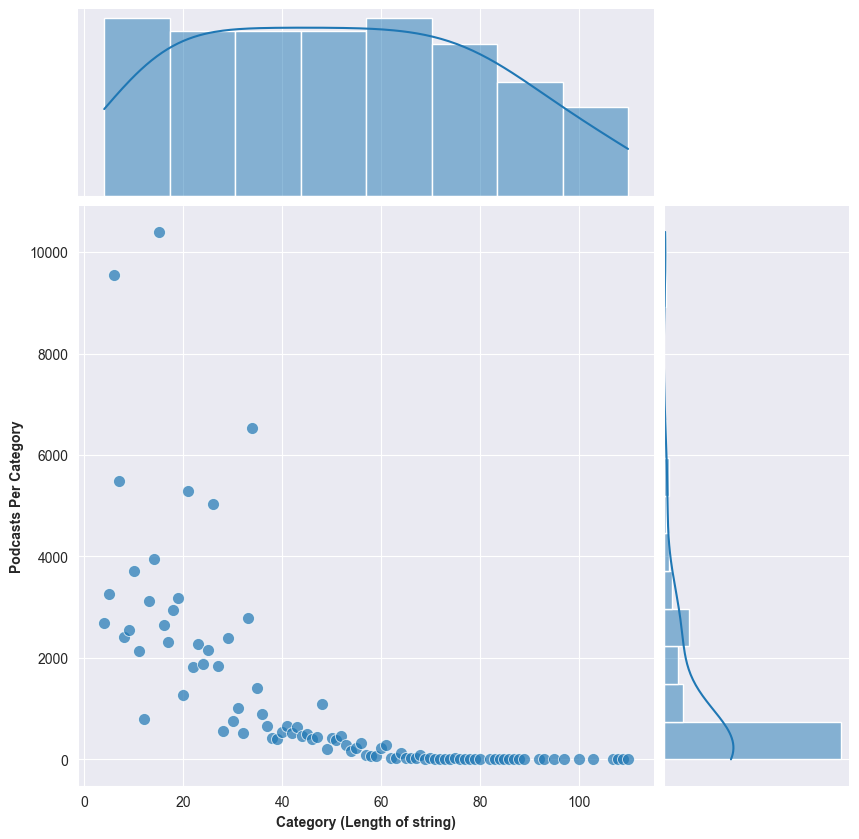

In [207]:
plt.figure(figsize=(12,8))
g = sns.JointGrid(
    data=visualizing_the_rabbit_hole,
    x="len_category",
    y="count",
    height=8.5,
    ratio=3,
    space=0.05,
)
g.ax_joint.set_xlabel("Category (Length of string)", fontweight="bold")
g.ax_joint.set_ylabel("Podcasts Per Category", fontweight="bold")
g.plot_joint(sns.scatterplot, s=75, alpha=0.7)
g.plot_marginals(sns.histplot, kde=True)

In [208]:
combined_removed_dupe_df

,podcast_id,category1,category2,category3,category4,category5,category6,category7,category8,category9,...,category11,category12,category13,category14,category15,category16,category17,category18,category19,category20
0,fa8c359031380cd4f3b38358c8a75f92,business,None,careers,education,None,self,improvement,society,culture,...,None,personal,journals,None,None,philosophy,None,None,philosophy,philosophy
1,f42588c1a44208a1fdacaa2ad9aa4026,comedy,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,a49be502b0d24058a786c3bce49bfd9d,sports,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,ca3bf8ffc21966a7c134104ccd2dd015,education,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,ca3d9d11912a3263225ad086ee857aa0,tv,film,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110019,fbc0fb2cbef6b093feb95c12f217359b,christianity,religion,spirituality,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
110020,fbcca0f759aea353febea58db515cebe,health,fitness,society,culture,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
110021,e1992c48c8a809e481e0a54cf986a74d,education,None,self,improvement,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
110022,e19b878961b830b3c5159568959d41d7,business,management,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


We are continuing this rabbit hole, this time we change all the empty fields into 0 and if there is a sub category we set it to = 1

In [209]:
%%sql
rabbit_hole_1_and_0_df <<
SELECT podcast_id, 
CASE WHEN TRIM(cat1) = '' THEN 0 ELSE 1 END as category1,
CASE WHEN TRIM(cat2) = '' THEN 0 ELSE 1 END as category2,
CASE WHEN TRIM(cat3) = '' THEN 0 ELSE 1 END as category3,
CASE WHEN TRIM(cat4) = '' THEN 0 ELSE 1 END as category4,
CASE WHEN TRIM(cat5) = '' THEN 0 ELSE 1 END as category5,
CASE WHEN TRIM(cat6) = '' THEN 0 ELSE 1 END as category6,
CASE WHEN TRIM(cat7) = '' THEN 0 ELSE 1 END as category7,
CASE WHEN TRIM(cat8) = '' THEN 0 ELSE 1 END as category8,
CASE WHEN TRIM(cat9) = '' THEN 0 ELSE 1 END as category9,
CASE WHEN TRIM(cat10) = '' THEN 0 ELSE 1 END as category10,
CASE WHEN TRIM(cat11) = '' THEN 0 ELSE 1 END as category11,
CASE WHEN TRIM(cat12) = '' THEN 0 ELSE 1 END as category12,
CASE WHEN TRIM(cat13) = '' THEN 0 ELSE 1 END as category13,
CASE WHEN TRIM(cat14) = '' THEN 0 ELSE 1 END as category14,
CASE WHEN TRIM(cat15) = '' THEN 0 ELSE 1 END as category15,
CASE WHEN TRIM(cat16) = '' THEN 0 ELSE 1 END as category16,
CASE WHEN TRIM(cat17) = '' THEN 0 ELSE 1 END as category17,
CASE WHEN TRIM(cat18) = '' THEN 0 ELSE 1 END as category18,
CASE WHEN TRIM(cat19) = '' THEN 0 ELSE 1 END as category19,
CASE WHEN TRIM(cat20) = '' THEN 0 ELSE 1 END as category20,
FROM removed_dupe_cat_df

Running query in 'duckdb'

We find the amount of sub categories for each podcast

In [210]:
%%sql
sub_category_count_df <<
SELECT podcast_id, category1 + category2 + category3 + category4 + 
category5 + category6 + category7 + category8 + category9 + 
category10 + category11 + category12 + category13 + 
category14 + category15 + category16 + category17 + 
category18 + category19 + category20 AS nr_of_subcategories
FROM rabbit_hole_1_and_0_df
ORDER BY nr_of_subcategories DESC

Running query in 'duckdb'

In [211]:
sub_category_count_df

,podcast_id,nr_of_subcategories
0,c7c3acaf63bd2e97631c2701c135ae38,13
1,fa8c359031380cd4f3b38358c8a75f92,12
2,b80b40b6b6787935970e5153fdfcfd4c,12
3,d072e6503d712904eb5a402a51fbe7d6,11
4,f160109d6eeb3bb70efbc5238bb84485,11
...,...,...
110019,e6526010a5b7e6f917c9cfe8d369485a,1
110020,e65f08f575848cab23d00a559255b158,1
110021,e601684e900b22c6a8c5204d6e6b61fd,1
110022,e610906e76fe5ac9c74dc173170f514c,1


In [212]:
%%sql
sub_categories_podcast_reviews_df <<
WITH t1 AS(
    SELECT nr_of_subcategories, COUNT(podcast_id) AS nr_of_podcasts_with_subcategories
    FROM sub_category_count_df
    GROUP BY nr_of_subcategories
)
SELECT r.podcast,r.num_of_reviews, t1.nr_of_subcategories, t1.nr_of_podcasts_with_subcategories, 
FROM t1
JOIN sub_category_count_df scc
ON t1.nr_of_subcategories = scc.nr_of_subcategories
JOIN one_review_df r
ON scc.podcast_id = r.podcast_id 

Running query in 'duckdb'

In [213]:
%%sql
sub_cat_tot_podcast <<
SELECT DISTINCT nr_of_subcategories AS subcategories, nr_of_podcasts_with_subcategories AS podcasts
FROM sub_categories_podcast_reviews_df

Running query in 'duckdb'

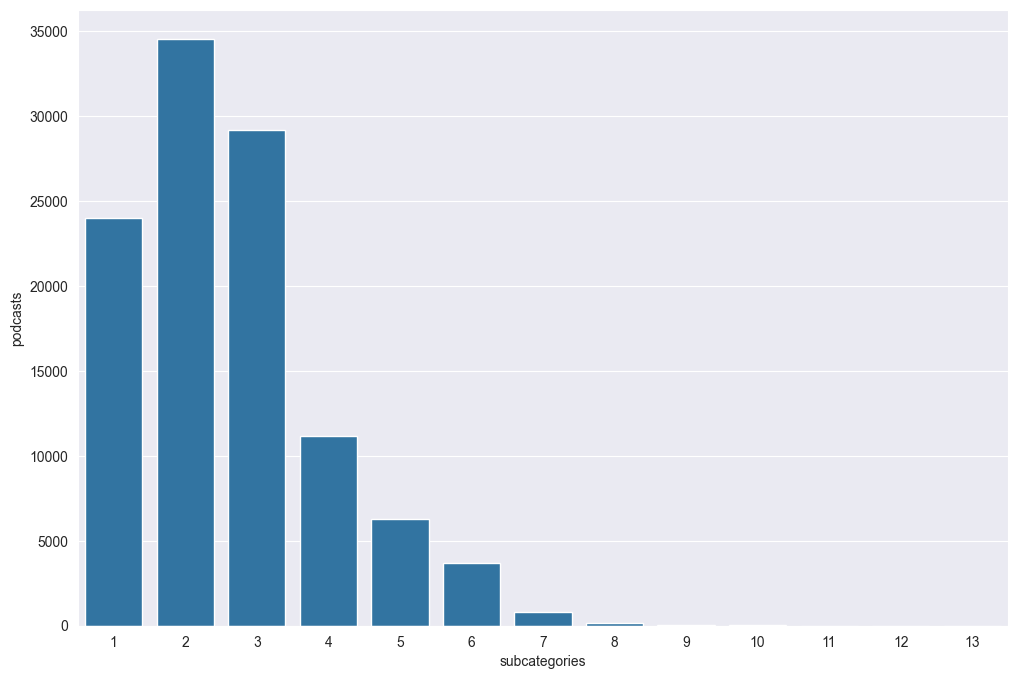

In [214]:
plt.figure(figsize=(12,8))
g = sns.barplot(
    data=sub_cat_tot_podcast,
    x="subcategories",
    y="podcasts",
)

In [215]:
sub_categories_podcast_reviews_df

,podcast,num_of_reviews,nr_of_subcategories,nr_of_podcasts_with_subcategories
0,Crime Junkie,31052,2,34550
1,My Favorite Murder with Karen Kilgariff and Ge...,9727,3,29210
2,The Ben Shapiro Show,7464,1,24033
3,True Crime Obsessed,6677,4,11180
4,Wow in the World,5565,5,6292
...,...,...,...,...
109989,Immersion Breaking,1,7,802
109990,DA SYLVA Podcast,1,1,24033
109991,Tails Of The Cowstomer: Alternative Season,1,2,34550
109992,ya:Oi,1,3,29210


In [216]:
%%sql
visualizing_sub_cat_review <<
WITH t1 AS(
SELECT nr_of_subcategories AS subcategories, SUM(num_of_reviews) AS tot_reviews, MAX(num_of_reviews) AS max_reviews_pp, MIN(num_of_reviews) AS min_reviews_pp
FROM sub_categories_podcast_reviews_df
GROUP BY subcategories),
t2 AS(
SELECT nr_of_subcategories AS subcategories, COUNT(*) AS podcasts
FROM sub_categories_podcast_reviews_df
GROUP BY subcategories
)
SELECT t1.subcategories, t2.podcasts, t1.tot_reviews, t1.tot_reviews/t2.podcasts AS avg_nr_of_review_per_podcast, t1.max_reviews_pp, t1.min_reviews_pp,
FROM t1
JOIN t2
ON t1.subcategories = t2.subcategories


Running query in 'duckdb'

In [217]:
visualizing_sub_cat_review

,subcategories,podcasts,tot_reviews,avg_nr_of_review_per_podcast,max_reviews_pp,min_reviews_pp
0,11,7,140.0,20.000000,50,1
1,1,24024,278771.0,11.603854,7464,1
2,5,6290,171226.0,27.221940,5565,1
3,9,45,1095.0,24.333333,217,1
4,3,29205,506445.0,17.341037,9727,1
5,6,3692,103108.0,27.927411,3791,1
6,12,2,54.0,27.000000,50,4
7,7,802,38692.0,48.244389,4049,1
8,8,186,12822.0,68.935484,1204,1
9,13,1,230.0,230.000000,230,230


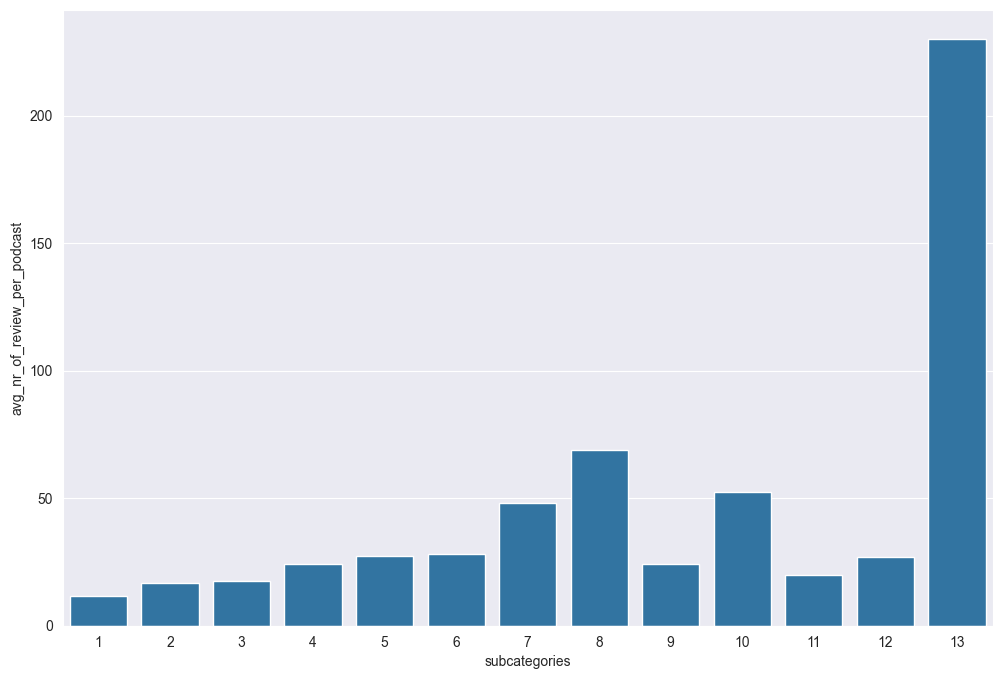

In [218]:
plt.figure(figsize=(12,8))
g = sns.barplot(
    data=visualizing_sub_cat_review,
    x="subcategories",
    y="avg_nr_of_review_per_podcast",
)

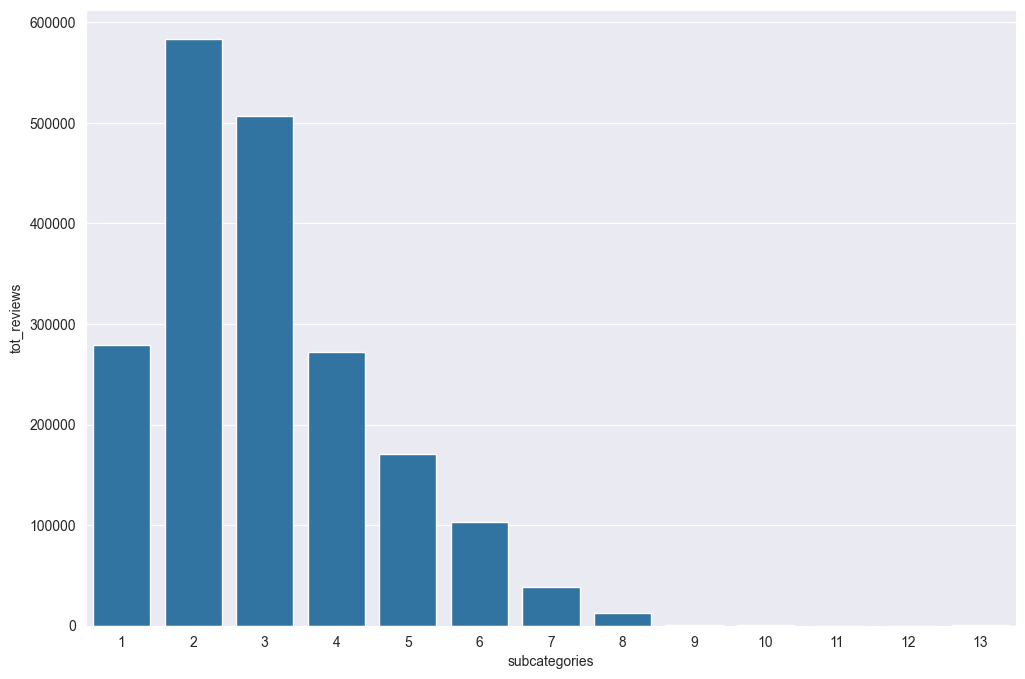

In [219]:
plt.figure(figsize=(12,8))
g = sns.barplot(
    data=visualizing_sub_cat_review,
    x="subcategories",
    y="tot_reviews",
)

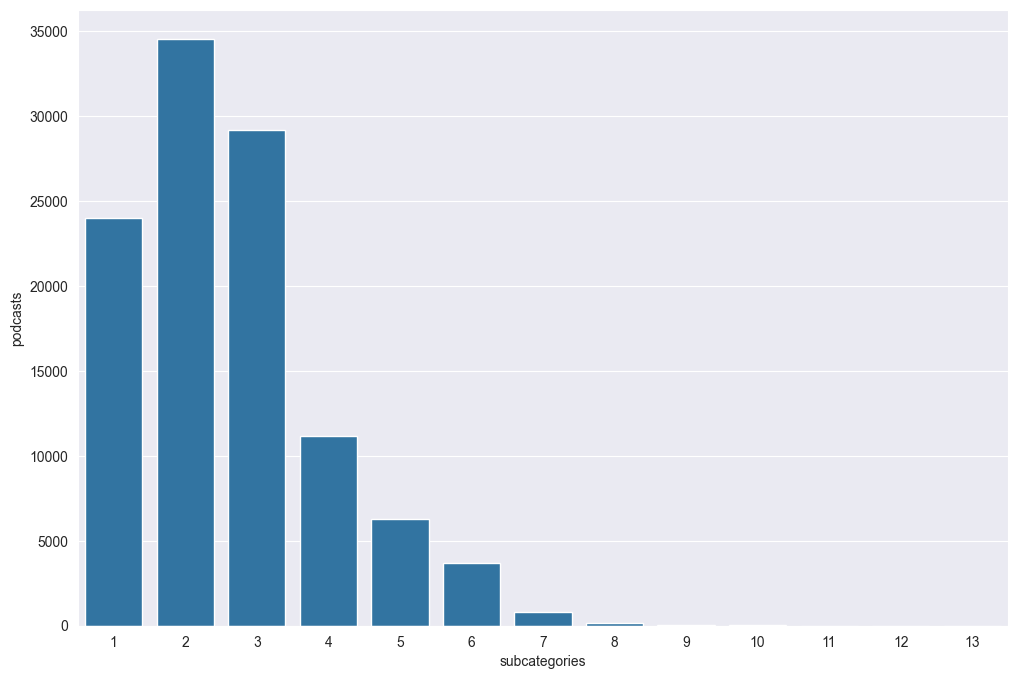

In [220]:
plt.figure(figsize=(12,8))
g = sns.barplot(
    data=visualizing_sub_cat_review,
    x="subcategories",
    y="podcasts",
)